In [1]:
# imports
import imageio
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from skimage import measure
from skimage import morphology

from skimage.segmentation import watershed
from skimage.filters import laplace, gaussian
from skimage.feature import peak_local_max

In [2]:
# experimental parameters
h_to_um  = 1 / 100
xy_to_um = 567 / 1024

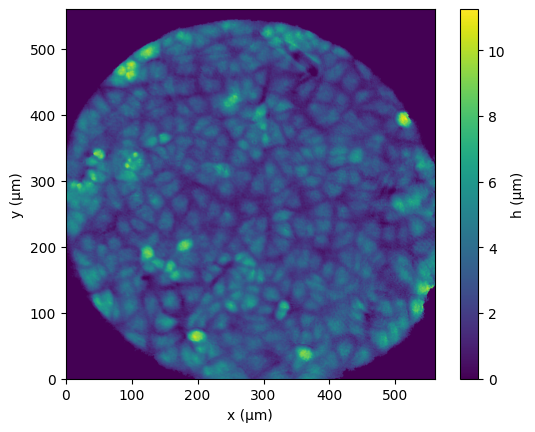

In [3]:
# load tiff
path = "../../../data/raw/holomonitor_20240516_A2-1/"
image = imageio.v2.imread(f"{path}MDCK-li_reg_zero_corr_1.tiff")

# file used to mask out regions outside cells
mask  = imageio.v2.imread(f"{path}mask.tiff") > 0

# convert to um
image = image * h_to_um
image *= mask

# plot
plt.imshow(image, extent=[0, len(image)*xy_to_um, 0, len(image[0])*xy_to_um])
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.colorbar(label="h (µm)")

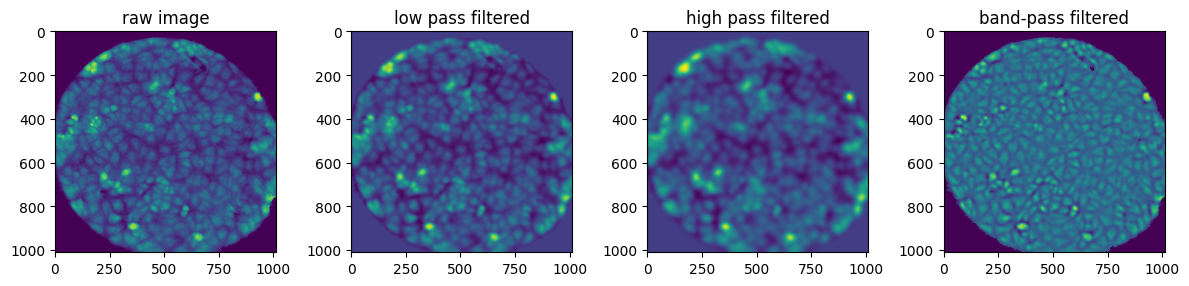

In [4]:
# perform band-pass filtering on image

# size of kernel
s_high = 5  # high pass filter
s_low = 10  # low pass filter

# set empty regions to mean to avoid edge effects
im_copy = np.copy(image)
im_copy[im_copy == 0] = np.mean(im_copy)

# band-pass filtered image
im_low_pass  = sc.ndimage.gaussian_filter(im_copy, s_low)
im_high_pass = sc.ndimage.gaussian_filter(im_copy, s_high)
im_band_pass = im_high_pass - im_low_pass

# normalizing and setting empty regions to 0
im_norm = ((im_band_pass - im_band_pass.min()) / (im_band_pass.max() - im_band_pass.min()))
im_norm[image == 0] = 0


fig, ax = plt.subplots(1,4, figsize=(12, 4))
ax[0].imshow(image)
ax[1].imshow(im_high_pass)
ax[2].imshow(im_low_pass)
ax[3].imshow(im_norm)

ax[0].set(title="raw image")
ax[1].set(title="low pass filtered")
ax[2].set(title="high pass filtered")
ax[3].set(title="band-pass filtered")
fig.tight_layout()

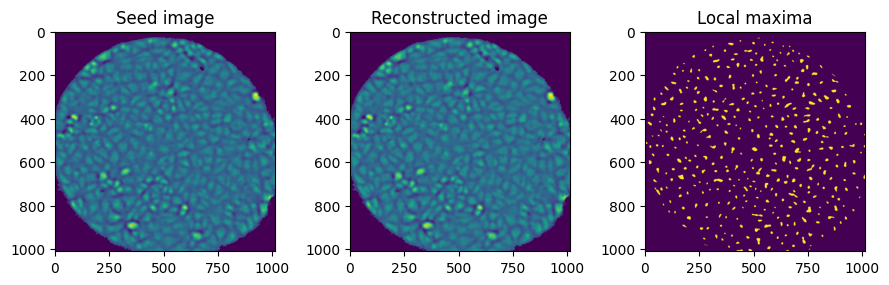

In [5]:
# Detect cell maxima
# Using MATLABs imextendedmax: https://se.mathworks.com/help/images/ref/imextendedmax.html
H = 0.03

# connecting regions marked by local maxima
mask = im_norm          # max allowed value at every pixel
seed = im_norm - H      # initial values before reconstruction
reconstruction = morphology.reconstruction(seed, mask, method='dilation')
hmax = morphology.local_maxima(reconstruction)

# remove very small maxima
min_size = 20
hmax = morphology.remove_small_objects(hmax, min_size=min_size) 

fig, ax = plt.subplots(1,3, figsize=(9, 4))
ax[0].imshow(seed)
ax[1].imshow(reconstruction)
ax[2].imshow(hmax)

ax[0].set(title="Seed image")
ax[1].set(title="Reconstructed image")
ax[2].set(title="Local maxima")
fig.tight_layout()

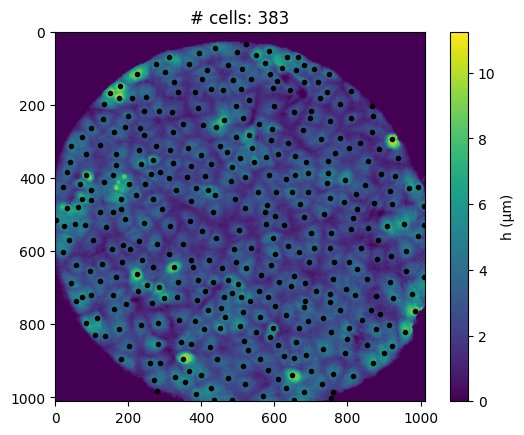

In [6]:
# get cell center positions

im_label  = measure.label(hmax)
regprop   = measure.regionprops(im_label, image)
positions = np.array([[int(r.centroid[1]), 
                       int(r.centroid[0])] for r in regprop])



# plot
plt.imshow(image)
plt.plot(*positions.T, 'k.')
plt.colorbar(label="h (µm)")
plt.title(f"# cells: {len(positions)}");

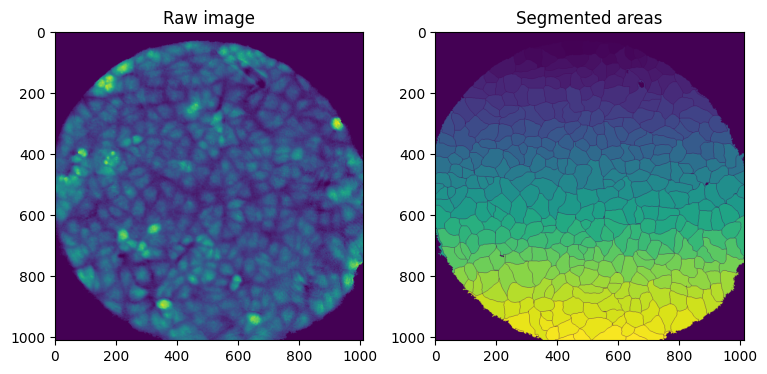

In [7]:
# segment cell areas

# matrix of cell centers with labels
im_seed = np.zeros(image.shape, dtype=int)
i = 1
for y,x in positions:
    im_seed[x,y] = i
    i += 1

cell_areas = watershed(-im_norm, im_seed, watershed_line=True, connectivity=1)

# remove empty areas
cell_mask = (image > 0)
cell_areas = cell_areas*cell_mask



fig, ax = plt.subplots(1,2, figsize=(9, 4))
ax[0].imshow(image)
ax[1].imshow(cell_areas)

ax[0].set(title="Raw image")
ax[1].set(title="Segmented areas");

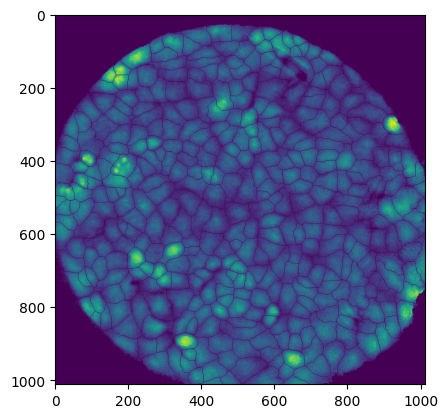

In [12]:
cell_edges = (cell_areas == 0)
cell_edges = (cell_edges == 0)
plt.imshow(cell_edges * image)

11.459155902616464


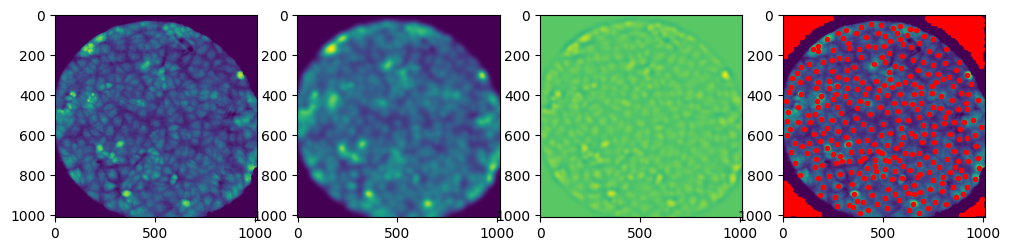

In [19]:
# detect cell

particle_size = 12
gaussian_kernel = particle_size**2/2/(2*np.pi)
print(gaussian_kernel)

gauss = gaussian(image, gaussian_kernel)
lap = laplace(gauss,ksize=5)

coordinates = peak_local_max(lap, min_distance=particle_size)

fig, ax = plt.subplots(1,4, figsize=(12, 4))
ax[0].imshow(image)
ax[1].imshow(gauss)
ax[2].imshow(lap)
ax[3].imshow(image)
ax[3].plot(coordinates[:, 1], coordinates[:, 0], 'r.')